# Follow-Up Analysis Notebook

This notebook addresses specific tasks from the December 2025 meeting:

1. **Iron/EC Ratio Analysis** - Analyze the relationship between iron and EC concentrations
2. **Fix Delhi Axis Scaling** - Correct plots where axes extend to 60 when max is ~20
3. **Remove Delhi Green Wavelength Outliers** - Identify and exclude 4-7 problematic points
4. **Summary Tables** - Create comprehensive tables with slopes and R² values
5. **Maintain Excluded Points Registry** - Track all outliers throughout analysis

---



## 1. Setup and Imports



In [88]:
# Add scripts folder to path
import sys
sys.path.insert(0, './scripts')

# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime

# Import from modular scripts
from config import (
    SITES, PROCESSED_SITES_DIR, FILTER_DATA_PATH,
    MAC_VALUE, FLOW_FIX_PERIODS, MIN_EC_THRESHOLD,
    SMOOTH_RAW_THRESHOLDS, CROSS_COMPARISONS
)

from outliers import (
    EXCLUDED_SAMPLES, MANUAL_OUTLIERS,
    apply_exclusion_flags, apply_threshold_flags,
    get_clean_data, print_exclusion_summary,
    identify_outlier_dates
)

from data_matching import (
    load_aethalometer_data, load_filter_data,
    match_aeth_filter_data, match_all_parameters,
    match_with_smooth_raw_info, add_flow_period_column,
    get_site_code, get_site_color, print_data_summary
)

from plotting_legacy import (
    calculate_regression_stats,
    plot_crossplot, plot_before_after_comparison,
    create_tiled_threshold_plots, plot_smooth_raw_distribution,
    plot_bc_timeseries, plot_multiwavelength_bc,
    print_comparison_table
)

# Configure matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("="*60)
print("FOLLOW-UP ANALYSIS NOTEBOOK")
print("="*60)
print(f"\nSites configured: {list(SITES.keys())}")
print(f"MAC value: {MAC_VALUE} m²/g")
print(f"Analysis date: {datetime.now().strftime('%Y-%m-%d')}")



FOLLOW-UP ANALYSIS NOTEBOOK

Sites configured: ['Beijing', 'Delhi', 'JPL', 'Addis_Ababa']
MAC value: 10 m²/g
Analysis date: 2026-01-07


## 2. Load Data



In [89]:
# Load all aethalometer datasets
aethalometer_data = load_aethalometer_data()

# Load filter dataset
filter_data = load_filter_data()

# Print data summary
print_data_summary(aethalometer_data, filter_data)



Loaded Beijing: 590 records, 2022-02-23 to 2024-10-07
Loaded Delhi: 289 records, 2022-06-27 to 2024-07-01
Loaded JPL: 765 records, 2021-11-08 to 2024-08-14
Loaded Addis_Ababa: 515 records, 2022-12-06 to 2024-09-22

Total sites loaded: 4
Filter dataset loaded: 44493 measurements
Sites: ['CHTS' 'ETAD' 'INDH' 'USPA']
Date range: 2013-06-28 to 2024-12-08

DATA SUMMARY

Beijing:
  Records: 590
  Date range: 2022-02-23 to 2024-10-07
  Days with IR BC: 222 (37.6%)

Delhi:
  Records: 289
  Date range: 2022-06-27 to 2024-07-01
  Days with IR BC: 113 (39.1%)

JPL:
  Records: 765
  Date range: 2021-11-08 to 2024-08-14
  Days with IR BC: 489 (63.9%)

Addis_Ababa:
  Records: 515
  Date range: 2022-12-06 to 2024-09-22
  Days with IR BC: 515 (100.0%)

Filter data: 44493 measurements
  Sites: ['CHTS', 'ETAD', 'INDH', 'USPA']
  Parameters: 62


## 3. Exclusion Registry

Maintain a comprehensive registry of all excluded points throughout the analysis.
This ensures transparency and reproducibility.



In [90]:
# Initialize comprehensive exclusion registry
EXCLUSION_REGISTRY = {
    'manual_outliers': {},      # From EXCLUDED_SAMPLES in outliers.py
    'delhi_green_outliers': [], # New: Delhi green wavelength outliers
    'threshold_outliers': {},   # From threshold-based filtering
    'summary': {}               # Summary counts per site
}

# Copy existing manual outliers to registry
for site, exclusions in EXCLUDED_SAMPLES.items():
    EXCLUSION_REGISTRY['manual_outliers'][site] = exclusions.copy()
    print(f"{site}: {len(exclusions)} pre-existing manual exclusion(s)")

print("\nExclusion registry initialized.")



Beijing: 1 pre-existing manual exclusion(s)
Delhi: 2 pre-existing manual exclusion(s)
JPL: 2 pre-existing manual exclusion(s)
Addis_Ababa: 0 pre-existing manual exclusion(s)

Exclusion registry initialized.


---
# TASK 1: Delhi Green Wavelength Outlier Removal

Identify and remove 4-7 outlier points in Delhi green wavelength data, then replot time series.



## 4. Delhi Green Wavelength Outlier Analysis



In [91]:
# Focus on Delhi data
if 'Delhi, India (INDH)' in aethalometer_data:
    delhi_df = aethalometer_data['Delhi, India (INDH)'].copy()
    site_config = SITES['Delhi, India (INDH)']
    
    print("="*60)
    print("DELHI GREEN WAVELENGTH OUTLIER ANALYSIS")
    print("="*60)
    
    # Check available wavelength columns
    wavelength_cols = [col for col in delhi_df.columns if 'BCc' in col]
    print(f"\nAvailable BC columns: {wavelength_cols}")
    
    # Focus on Green BCc
    green_col = 'Green BCc'
    if green_col in delhi_df.columns:
        green_data = delhi_df[[green_col, 'day_9am']].dropna()
        print(f"\nGreen BCc data points: {len(green_data)}")
        print(f"  Mean: {green_data[green_col].mean():.1f} ng/m³")
        print(f"  Median: {green_data[green_col].median():.1f} ng/m³")
        print(f"  Std: {green_data[green_col].std():.1f} ng/m³")
        print(f"  Min: {green_data[green_col].min():.1f} ng/m³")
        print(f"  Max: {green_data[green_col].max():.1f} ng/m³")
else:
    print("Delhi data not found!")



Delhi data not found!


In [92]:
# Visualize Green BCc distribution to identify outliers
if 'Delhi, India (INDH)' in aethalometer_data:
    delhi_df = aethalometer_data['Delhi, India (INDH)'].copy()
    green_col = 'Green BCc'
    
    if green_col in delhi_df.columns:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # 1. Time series with potential outliers highlighted
        ax1 = axes[0]
        valid_data = delhi_df[delhi_df[green_col].notna()].copy()
        
        # Calculate IQR-based outlier threshold
        Q1 = valid_data[green_col].quantile(0.25)
        Q3 = valid_data[green_col].quantile(0.75)
        IQR = Q3 - Q1
        upper_threshold = Q3 + 1.5 * IQR
        lower_threshold = Q1 - 1.5 * IQR
        
        # Also use a simple percentile threshold
        pct_99 = valid_data[green_col].quantile(0.99)
        pct_95 = valid_data[green_col].quantile(0.95)
        
        print(f"\nOutlier Detection Thresholds:")
        print(f"  IQR method upper: {upper_threshold:.1f} ng/m³")
        print(f"  99th percentile: {pct_99:.1f} ng/m³")
        print(f"  95th percentile: {pct_95:.1f} ng/m³")
        
        # Identify outliers (using IQR method)
        outlier_mask = valid_data[green_col] > upper_threshold
        normal_mask = ~outlier_mask
        
        ax1.scatter(valid_data.loc[normal_mask, 'day_9am'], 
                   valid_data.loc[normal_mask, green_col],
                   color=site_config['color'], alpha=0.6, s=30, label='Normal')
        ax1.scatter(valid_data.loc[outlier_mask, 'day_9am'], 
                   valid_data.loc[outlier_mask, green_col],
                   color='red', alpha=0.9, s=100, marker='X', linewidths=2,
                   label=f'Outliers (n={outlier_mask.sum()})')
        ax1.axhline(y=upper_threshold, color='red', linestyle='--', alpha=0.7,
                   label=f'IQR threshold: {upper_threshold:.0f}')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Green BCc (ng/m³)')
        ax1.set_title('Delhi Green BCc Time Series')
        ax1.legend(loc='upper right', fontsize=8)
        ax1.tick_params(axis='x', rotation=45)
        
        # 2. Histogram
        ax2 = axes[1]
        ax2.hist(valid_data[green_col], bins=50, color=site_config['color'], 
                alpha=0.7, edgecolor='black', linewidth=0.5)
        ax2.axvline(x=upper_threshold, color='red', linestyle='--', linewidth=2,
                   label=f'IQR threshold: {upper_threshold:.0f}')
        ax2.axvline(x=pct_95, color='orange', linestyle='--', linewidth=2,
                   label=f'95th pct: {pct_95:.0f}')
        ax2.set_xlabel('Green BCc (ng/m³)')
        ax2.set_ylabel('Count')
        ax2.set_title('Distribution of Green BCc')
        ax2.legend(fontsize=8)
        
        # 3. Box plot comparison across wavelengths
        ax3 = axes[2]
        wavelengths = ['UV BCc', 'Blue BCc', 'Green BCc', 'Red BCc', 'IR BCc']
        available_wl = [wl for wl in wavelengths if wl in delhi_df.columns]
        
        box_data = [delhi_df[wl].dropna().values for wl in available_wl]
        bp = ax3.boxplot(box_data, labels=[wl.replace(' BCc', '') for wl in available_wl],
                        patch_artist=True)
        for patch in bp['boxes']:
            patch.set_facecolor(site_config['color'])
            patch.set_alpha(0.6)
        ax3.set_ylabel('BC (ng/m³)')
        ax3.set_title('BC by Wavelength (Box Plot)')
        
        plt.tight_layout()
        plt.show()
        
        # Print outlier dates
        print(f"\n{'='*60}")
        print(f"IDENTIFIED OUTLIERS ({outlier_mask.sum()} points)")
        print(f"{'='*60}")
        outlier_dates = valid_data.loc[outlier_mask, ['day_9am', green_col]].sort_values(green_col, ascending=False)
        for idx, row in outlier_dates.iterrows():
            print(f"  {row['day_9am'].strftime('%Y-%m-%d')}: {row[green_col]:.1f} ng/m³")



In [93]:
# Define Delhi green wavelength outliers explicitly
# Based on visual inspection and statistical thresholds

if 'Delhi, India (INDH)' in aethalometer_data:
    delhi_df = aethalometer_data['Delhi, India (INDH)'].copy()
    green_col = 'Green BCc'
    
    if green_col in delhi_df.columns:
        valid_data = delhi_df[delhi_df[green_col].notna()].copy()
        
        # Calculate threshold
        Q1 = valid_data[green_col].quantile(0.25)
        Q3 = valid_data[green_col].quantile(0.75)
        IQR = Q3 - Q1
        upper_threshold = Q3 + 1.5 * IQR
        
        # Identify outlier dates
        outlier_mask = valid_data[green_col] > upper_threshold
        outlier_records = valid_data.loc[outlier_mask, ['day_9am', green_col]].copy()
        
        # Store in exclusion registry
        delhi_green_outliers = []
        for idx, row in outlier_records.iterrows():
            delhi_green_outliers.append({
                'date': row['day_9am'].strftime('%Y-%m-%d'),
                'value': row[green_col],
                'reason': f'Green BCc outlier (IQR method): {row[green_col]:.1f} ng/m³ > threshold {upper_threshold:.1f}'
            })
        
        EXCLUSION_REGISTRY['delhi_green_outliers'] = delhi_green_outliers
        
        print(f"\n{'='*60}")
        print(f"DELHI GREEN OUTLIERS ADDED TO REGISTRY")
        print(f"{'='*60}")
        print(f"Total outliers identified: {len(delhi_green_outliers)}")
        print(f"Threshold used: {upper_threshold:.1f} ng/m³ (IQR method)")
        print(f"\nOutlier dates:")
        for outlier in delhi_green_outliers:
            print(f"  {outlier['date']}: {outlier['value']:.1f} ng/m³")



In [94]:
# Create BEFORE/AFTER comparison for Delhi green wavelength

if 'Delhi, India (INDH)' in aethalometer_data and len(EXCLUSION_REGISTRY['delhi_green_outliers']) > 0:
    delhi_df = aethalometer_data['Delhi, India (INDH)'].copy()
    green_col = 'Green BCc'
    site_config = SITES['Delhi, India (INDH)']
    
    # Get outlier dates
    outlier_dates = [pd.to_datetime(o['date']) for o in EXCLUSION_REGISTRY['delhi_green_outliers']]
    
    # Create outlier mask
    delhi_df['is_green_outlier'] = False
    for outlier_date in outlier_dates:
        date_mask = (delhi_df['day_9am'] >= outlier_date - pd.Timedelta(hours=12)) & \
                    (delhi_df['day_9am'] <= outlier_date + pd.Timedelta(hours=12))
        delhi_df.loc[date_mask, 'is_green_outlier'] = True
    
    valid_data = delhi_df[delhi_df[green_col].notna()].copy()
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # BEFORE: All data
    ax1 = axes[0]
    ax1.plot(valid_data['day_9am'], valid_data[green_col], 
            color=site_config['color'], alpha=0.7, linewidth=1)
    ax1.scatter(valid_data.loc[valid_data['is_green_outlier'], 'day_9am'],
               valid_data.loc[valid_data['is_green_outlier'], green_col],
               color='red', s=100, marker='X', linewidths=2, zorder=5,
               label=f'Outliers (n={valid_data["is_green_outlier"].sum()})')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Green BCc (ng/m³)')
    ax1.set_title('BEFORE: Delhi Green BCc (All Data)', fontsize=12, fontweight='bold')
    ax1.legend(loc='upper right')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3)
    
    # AFTER: Outliers removed
    ax2 = axes[1]
    clean_data = valid_data[~valid_data['is_green_outlier']].copy()
    ax2.plot(clean_data['day_9am'], clean_data[green_col], 
            color=site_config['color'], alpha=0.7, linewidth=1)
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Green BCc (ng/m³)')
    ax2.set_title(f'AFTER: Delhi Green BCc (n={len(clean_data)} points)', 
                 fontsize=12, fontweight='bold')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)
    
    # Match y-axis limits
    y_max = valid_data[green_col].max() * 1.05
    ax1.set_ylim(0, y_max)
    ax2.set_ylim(0, clean_data[green_col].max() * 1.05)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics comparison
    print(f"\n{'='*60}")
    print("BEFORE/AFTER STATISTICS COMPARISON")
    print(f"{'='*60}")
    print(f"\n{'Metric':<20s} {'Before':>15s} {'After':>15s} {'Change':>15s}")
    print("-"*65)
    
    before_mean = valid_data[green_col].mean()
    after_mean = clean_data[green_col].mean()
    print(f"{'Mean (ng/m³)':<20s} {before_mean:>15.1f} {after_mean:>15.1f} {after_mean-before_mean:>+15.1f}")
    
    before_median = valid_data[green_col].median()
    after_median = clean_data[green_col].median()
    print(f"{'Median (ng/m³)':<20s} {before_median:>15.1f} {after_median:>15.1f} {after_median-before_median:>+15.1f}")
    
    before_std = valid_data[green_col].std()
    after_std = clean_data[green_col].std()
    print(f"{'Std Dev (ng/m³)':<20s} {before_std:>15.1f} {after_std:>15.1f} {after_std-before_std:>+15.1f}")
    
    before_max = valid_data[green_col].max()
    after_max = clean_data[green_col].max()
    print(f"{'Max (ng/m³)':<20s} {before_max:>15.1f} {after_max:>15.1f} {after_max-before_max:>+15.1f}")
    
    print(f"{'N points':<20s} {len(valid_data):>15d} {len(clean_data):>15d} {len(clean_data)-len(valid_data):>+15d}")



---
# TASK 2: Fix Delhi Axis Scaling

Create Delhi plots with appropriate axis scaling (max ~20 instead of 60).



## 5. Delhi Axis Scaling Fix



In [95]:
# Match Delhi data for cross-plots
if 'Delhi, India (INDH)' in aethalometer_data:
    delhi_aeth = aethalometer_data['Delhi, India (INDH)']
    delhi_config = SITES['Delhi, India (INDH)']
    
    # Match aethalometer and filter data
    delhi_matched = match_all_parameters(
        'Delhi, India (INDH)', 
        delhi_config['code'], 
        delhi_aeth, 
        filter_data
    )
    
    if delhi_matched is not None and len(delhi_matched) >= 3:
        print(f"Delhi matched data: {len(delhi_matched)} points")
        
        # Show data ranges
        print(f"\nData ranges:")
        for col in ['ir_bcc', 'ftir_ec', 'hips_fabs', 'iron']:
            if col in delhi_matched.columns:
                valid = delhi_matched[col].dropna()
                if len(valid) > 0:
                    print(f"  {col}: {valid.min():.2f} - {valid.max():.2f} µg/m³")



In [96]:
# Function to create properly scaled cross-plot
def create_scaled_crossplot(ax, x_data, y_data, x_label, y_label, 
                            color, title, outlier_mask=None,
                            max_scale=None, add_buffer=1.1):
    """
    Create a cross-plot with appropriate axis scaling.
    
    Parameters:
    -----------
    max_scale : float, optional
        If provided, use this as the maximum axis value.
        If None, calculate from data with buffer.
    add_buffer : float
        Multiplier for auto-calculated max (default 1.1 = 10% buffer)
    """
    x_data = np.asarray(x_data)
    y_data = np.asarray(y_data)
    
    # Valid data mask
    valid_mask = (~np.isnan(x_data)) & (~np.isnan(y_data))
    
    if outlier_mask is not None:
        outlier_mask = np.asarray(outlier_mask)
        clean_mask = valid_mask & ~outlier_mask
        outlier_plot_mask = valid_mask & outlier_mask
    else:
        clean_mask = valid_mask
        outlier_plot_mask = np.zeros(len(x_data), dtype=bool)
    
    x_clean = x_data[clean_mask]
    y_clean = y_data[clean_mask]
    
    if len(x_clean) < 3:
        ax.text(0.5, 0.5, 'Insufficient data', transform=ax.transAxes, 
                ha='center', va='center')
        return None
    
    # Calculate appropriate axis maximum
    if max_scale is None:
        data_max = max(x_clean.max(), y_clean.max())
        max_val = data_max * add_buffer
    else:
        max_val = max_scale
    
    # Plot clean data
    ax.scatter(x_clean, y_clean, color=color, alpha=0.6, s=80,
               edgecolors='black', linewidth=0.5, label=f'Data (n={len(x_clean)})')
    
    # Plot outliers
    if outlier_plot_mask.any():
        ax.scatter(x_data[outlier_plot_mask], y_data[outlier_plot_mask],
                   color='red', alpha=0.9, s=200, marker='X', linewidths=3,
                   label=f'Excluded (n={outlier_plot_mask.sum()})')
    
    # Calculate regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_clean, y_clean)
    r_squared = r_value ** 2
    
    # Plot regression line
    x_line = np.array([0, max_val])
    y_line = slope * x_line + intercept
    ax.plot(x_line, y_line, 'g-', linewidth=2, alpha=0.8, label='Best fit')
    
    # 1:1 line
    ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, linewidth=1.5, label='1:1 line')
    
    # Set axis limits - THIS IS THE KEY FIX
    ax.set_xlim(0, max_val)
    ax.set_ylim(0, max_val)
    ax.set_aspect('equal', adjustable='box')
    
    # Stats text
    sign = '+' if intercept >= 0 else '-'
    eq = f"y = {slope:.3f}x {sign} {abs(intercept):.2f}"
    stats_text = f"n = {len(x_clean)}\nR² = {r_squared:.3f}\n{eq}"
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    
    ax.set_xlabel(x_label, fontsize=11)
    ax.set_ylabel(y_label, fontsize=11)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.legend(loc='lower right', fontsize=8)
    ax.grid(True, alpha=0.3)
    
    return {
        'n': len(x_clean),
        'r_squared': r_squared,
        'slope': slope,
        'intercept': intercept,
        'p_value': p_value,
        'max_val_used': max_val
    }

print("Scaled cross-plot function defined.")



Scaled cross-plot function defined.


In [97]:
# Create Delhi plots with CORRECT axis scaling

if 'Delhi, India (INDH)' in aethalometer_data and delhi_matched is not None:
    delhi_config = SITES['Delhi, India (INDH)']
    
    # Apply exclusion flags
    delhi_flagged = apply_exclusion_flags(delhi_matched.copy(), 'Delhi, India (INDH)')
    outlier_mask = delhi_flagged['is_excluded'].values if 'is_excluded' in delhi_flagged.columns else None
    
    print("="*60)
    print("DELHI CROSS-PLOTS WITH CORRECTED AXIS SCALING")
    print("="*60)
    
    # Determine appropriate max scale from data
    all_values = []
    for col in ['ir_bcc', 'ftir_ec', 'hips_fabs']:
        if col in delhi_flagged.columns:
            all_values.extend(delhi_flagged[col].dropna().values)
    
    if all_values:
        data_max = max(all_values)
        recommended_max = np.ceil(data_max * 1.1)
        print(f"\nData maximum: {data_max:.2f} µg/m³")
        print(f"Recommended axis max: {recommended_max:.0f} µg/m³")
        print("(Previously incorrectly set to 60)")
    
    # Cross-plot comparisons
    delhi_comparisons = [
        ('ir_bcc', 'ftir_ec', 'Aethalometer IR BCc (µg/m³)', 'FTIR EC (µg/m³)', 
         'Delhi: Aethalometer BC vs FTIR EC'),
        ('ir_bcc', 'hips_fabs', 'Aethalometer IR BCc (µg/m³)', 'HIPS Fabs / MAC (µg/m³)',
         'Delhi: Aethalometer BC vs HIPS Fabs'),
        ('ftir_ec', 'hips_fabs', 'FTIR EC (µg/m³)', 'HIPS Fabs / MAC (µg/m³)',
         'Delhi: FTIR EC vs HIPS Fabs'),
    ]
    
    delhi_stats = {}
    
    for x_col, y_col, x_label, y_label, title in delhi_comparisons:
        if x_col not in delhi_flagged.columns or y_col not in delhi_flagged.columns:
            print(f"  Skipping {title}: missing columns")
            continue
        
        fig, axes = plt.subplots(1, 2, figsize=(16, 7))
        
        # LEFT: Incorrect scaling (simulated - showing what was wrong)
        ax1 = axes[0]
        stats_wrong = create_scaled_crossplot(
            ax1,
            delhi_flagged[x_col].values,
            delhi_flagged[y_col].values,
            x_label, y_label,
            delhi_config['color'],
            f"INCORRECT SCALING (max=60)\n{title}",
            outlier_mask=outlier_mask,
            max_scale=60  # The incorrect scaling
        )
        
        # RIGHT: Correct scaling (auto-calculated from data)
        ax2 = axes[1]
        stats_correct = create_scaled_crossplot(
            ax2,
            delhi_flagged[x_col].values,
            delhi_flagged[y_col].values,
            x_label, y_label,
            delhi_config['color'],
            f"CORRECTED SCALING\n{title}",
            outlier_mask=outlier_mask,
            max_scale=None,  # Auto-calculate
            add_buffer=1.15
        )
        
        plt.tight_layout()
        plt.show()
        
        if stats_correct:
            delhi_stats[title] = stats_correct
            print(f"  {title}")
            print(f"    Axis max used: {stats_correct['max_val_used']:.1f} (was 60)")
            print(f"    R² = {stats_correct['r_squared']:.3f}, Slope = {stats_correct['slope']:.3f}")
        print()



---
# TASK 3: Iron/EC Ratio Analysis

Analyze the relationship between iron and EC concentrations across all sites.



## 6. Iron/EC Ratio Analysis



In [98]:
# Match all parameters for each site
all_params_data = {}

for site_name in SITES:
    if site_name not in aethalometer_data:
        continue
    
    config = SITES[site_name]
    df_aeth = aethalometer_data[site_name]
    
    matched = match_all_parameters(
        site_name, config['code'], df_aeth, filter_data
    )
    
    if matched is not None and len(matched) >= 3:
        all_params_data[site_name] = matched
        
        # Check for iron data
        has_iron = 'iron' in matched.columns and matched['iron'].notna().any()
        has_ec = 'ftir_ec' in matched.columns and matched['ftir_ec'].notna().any()
        
        if has_iron and has_ec:
            n_both = ((matched['iron'].notna()) & (matched['ftir_ec'].notna())).sum()
            print(f"{site_name}: {n_both} points with both Iron and FTIR EC")
        else:
            print(f"{site_name}: Missing iron or EC data")
    else:
        print(f"{site_name}: Insufficient matched data")



Beijing: 171 points with both Iron and FTIR EC
Delhi: 27 points with both Iron and FTIR EC
JPL: 156 points with both Iron and FTIR EC
Addis_Ababa: 188 points with both Iron and FTIR EC


In [99]:
# Calculate Iron/EC ratio for each site

iron_ec_analysis = {}

print("="*60)
print("IRON/EC RATIO ANALYSIS")
print("="*60)

for site_name, matched_df in all_params_data.items():
    config = SITES[site_name]
    
    # Check if iron and EC data exist
    if 'iron' not in matched_df.columns or 'ftir_ec' not in matched_df.columns:
        print(f"\n{site_name}: Missing iron or EC columns")
        continue
    
    # Apply exclusion flags
    df_flagged = apply_exclusion_flags(matched_df.copy(), site_name)
    
    # Filter to points with both iron and EC
    valid_mask = (df_flagged['iron'].notna()) & (df_flagged['ftir_ec'].notna())
    
    # Exclude flagged outliers
    if 'is_excluded' in df_flagged.columns:
        clean_mask = valid_mask & ~df_flagged['is_excluded']
    else:
        clean_mask = valid_mask
    
    df_clean = df_flagged[clean_mask].copy()
    
    if len(df_clean) < 3:
        print(f"\n{site_name}: Insufficient data with both Iron and EC (n={len(df_clean)})")
        continue
    
    # Calculate Iron/EC ratio
    # Avoid division by zero
    df_clean['iron_ec_ratio'] = np.where(
        df_clean['ftir_ec'] > 0.01,  # Minimum EC threshold
        df_clean['iron'] / df_clean['ftir_ec'],
        np.nan
    )
    
    ratio_valid = df_clean['iron_ec_ratio'].dropna()
    
    print(f"\n{'-'*60}")
    print(f"{site_name}")
    print(f"{'-'*60}")
    print(f"  N samples: {len(ratio_valid)}")
    print(f"  Iron range: {df_clean['iron'].min():.3f} - {df_clean['iron'].max():.3f} µg/m³")
    print(f"  FTIR EC range: {df_clean['ftir_ec'].min():.3f} - {df_clean['ftir_ec'].max():.3f} µg/m³")
    print(f"\n  Iron/EC Ratio Statistics:")
    print(f"    Mean: {ratio_valid.mean():.3f}")
    print(f"    Median: {ratio_valid.median():.3f}")
    print(f"    Std: {ratio_valid.std():.3f}")
    print(f"    Min: {ratio_valid.min():.3f}")
    print(f"    Max: {ratio_valid.max():.3f}")
    print(f"    25th percentile: {ratio_valid.quantile(0.25):.3f}")
    print(f"    75th percentile: {ratio_valid.quantile(0.75):.3f}")
    
    # Store results
    iron_ec_analysis[site_name] = {
        'data': df_clean,
        'n': len(ratio_valid),
        'iron_mean': df_clean['iron'].mean(),
        'ec_mean': df_clean['ftir_ec'].mean(),
        'ratio_mean': ratio_valid.mean(),
        'ratio_median': ratio_valid.median(),
        'ratio_std': ratio_valid.std(),
        'ratio_min': ratio_valid.min(),
        'ratio_max': ratio_valid.max()
    }



IRON/EC RATIO ANALYSIS

------------------------------------------------------------
Beijing
------------------------------------------------------------
  N samples: 168
  Iron range: 49.890 - 3795.770 µg/m³
  FTIR EC range: -0.368 - 6.632 µg/m³

  Iron/EC Ratio Statistics:
    Mean: 604.423
    Median: 261.081
    Std: 3097.929
    Min: 76.536
    Max: 40175.061
    25th percentile: 210.723
    75th percentile: 367.585

------------------------------------------------------------
Delhi
------------------------------------------------------------
  N samples: 26
  Iron range: 266.430 - 1204.760 µg/m³
  FTIR EC range: -0.935 - 12.334 µg/m³

  Iron/EC Ratio Statistics:
    Mean: 131.297
    Median: 92.700
    Std: 104.930
    Min: 49.441
    Max: 416.592
    25th percentile: 70.667
    75th percentile: 124.201

------------------------------------------------------------
JPL
------------------------------------------------------------
  N samples: 155
  Iron range: 2.040 - 174.630 µg/m³

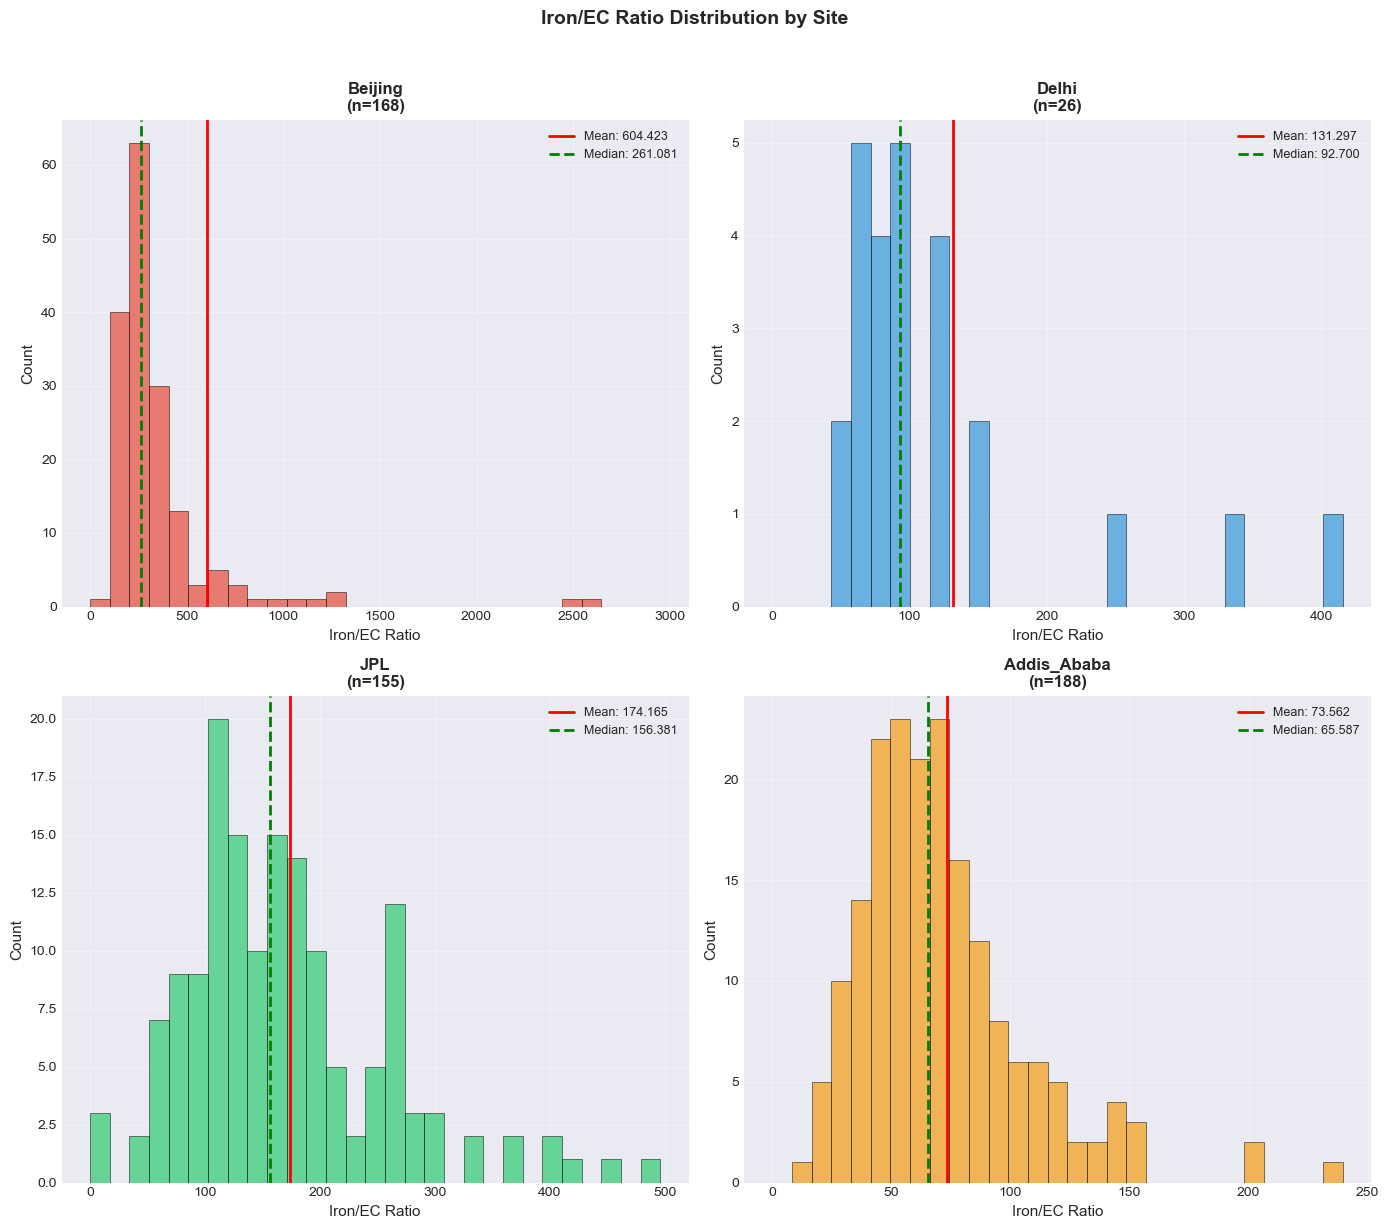

In [100]:
# Iron/EC Ratio Distribution Plots

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, (site_name, analysis) in enumerate(iron_ec_analysis.items()):
    if idx >= 4:
        break
    
    ax = axes[idx]
    config = SITES[site_name]
    df = analysis['data']
    ratio = df['iron_ec_ratio'].dropna()
    
    # Histogram
    bins = np.linspace(0, ratio.quantile(0.99), 30)
    ax.hist(ratio, bins=bins, color=config['color'], alpha=0.7, 
            edgecolor='black', linewidth=0.5)
    
    # Add mean and median lines
    ax.axvline(x=ratio.mean(), color='red', linestyle='-', linewidth=2,
               label=f'Mean: {ratio.mean():.3f}')
    ax.axvline(x=ratio.median(), color='green', linestyle='--', linewidth=2,
               label=f'Median: {ratio.median():.3f}')
    
    ax.set_xlabel('Iron/EC Ratio', fontsize=11)
    ax.set_ylabel('Count', fontsize=11)
    ax.set_title(f'{site_name}\n(n={len(ratio)})', fontsize=12, fontweight='bold')
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(len(iron_ec_analysis), 4):
    axes[idx].set_visible(False)

plt.suptitle('Iron/EC Ratio Distribution by Site', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()




IRON vs FTIR EC CORRELATION ANALYSIS

Beijing:
  R² = 0.137
  Slope = 133.477 (Iron per unit EC)
  p-value = 6.22e-07


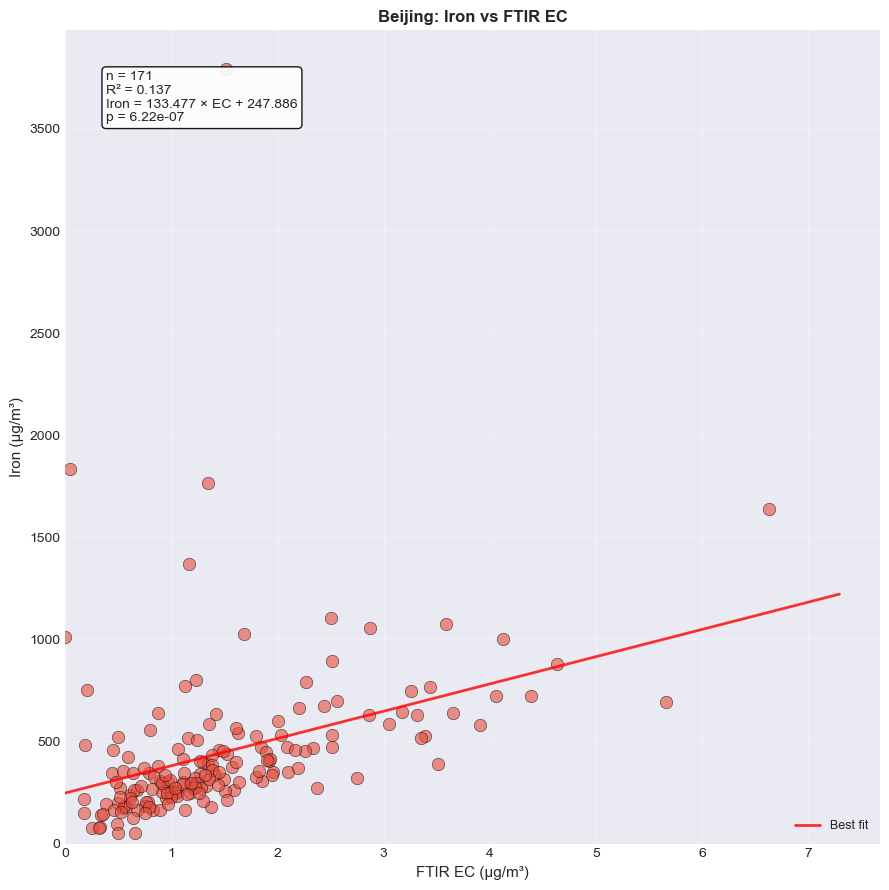


Delhi:
  R² = 0.052
  Slope = 17.209 (Iron per unit EC)
  p-value = 2.55e-01


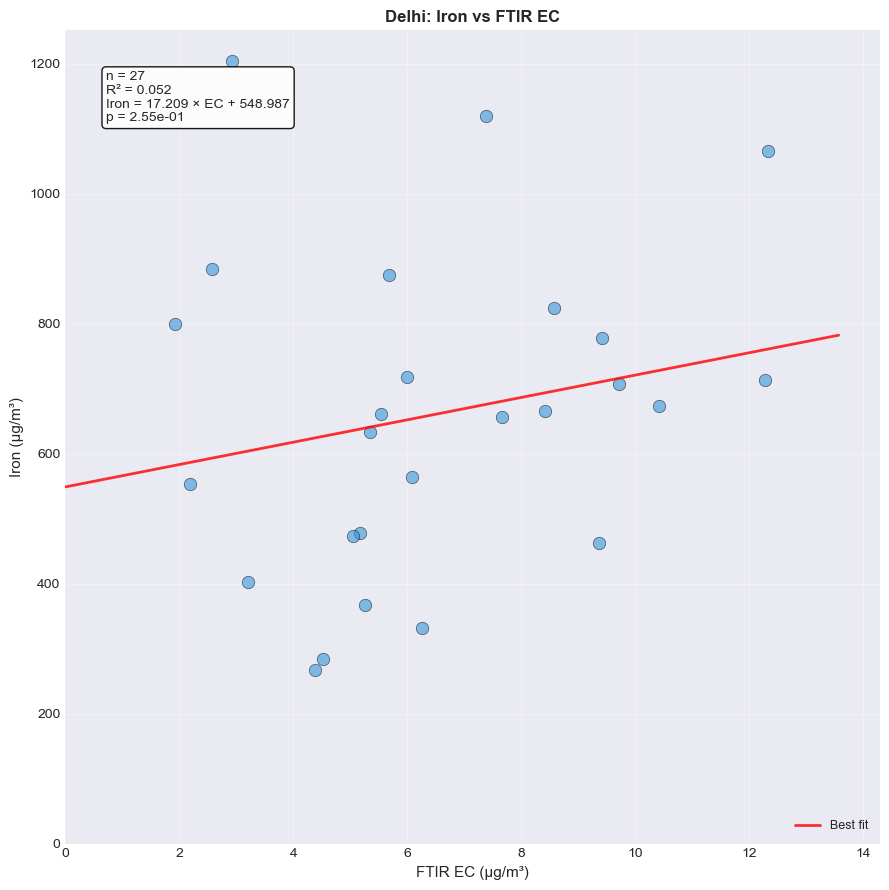


JPL:
  R² = 0.271
  Slope = 102.201 (Iron per unit EC)
  p-value = 3.12e-12


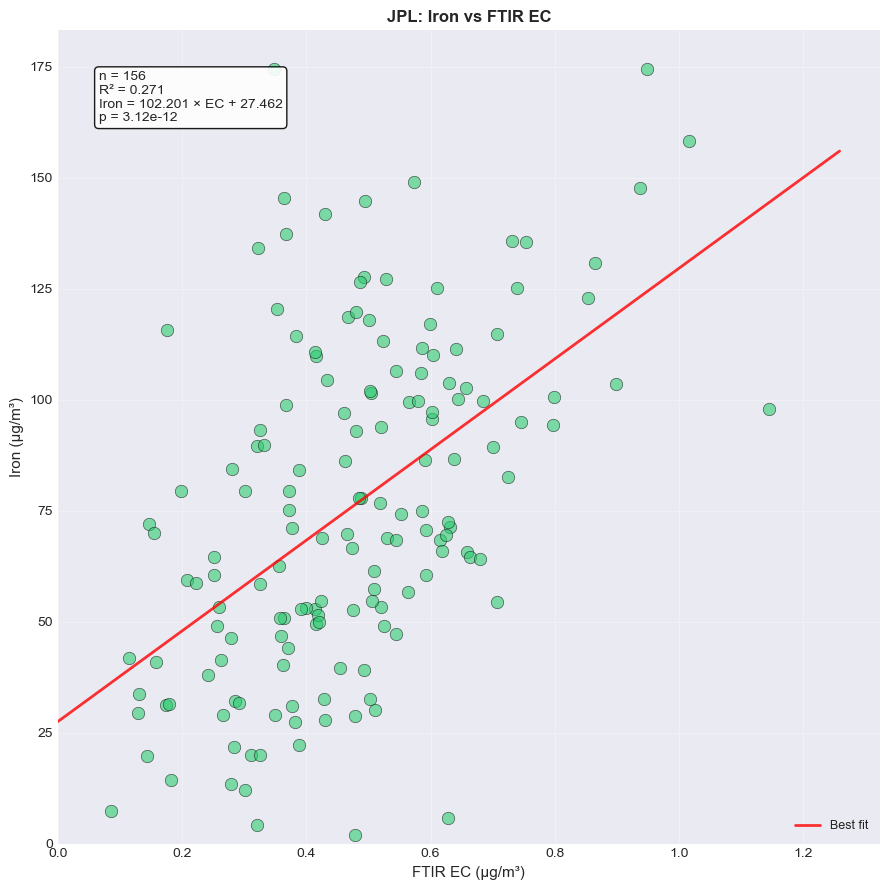


Addis_Ababa:
  R² = 0.211
  Slope = 34.111 (Iron per unit EC)
  p-value = 3.17e-11


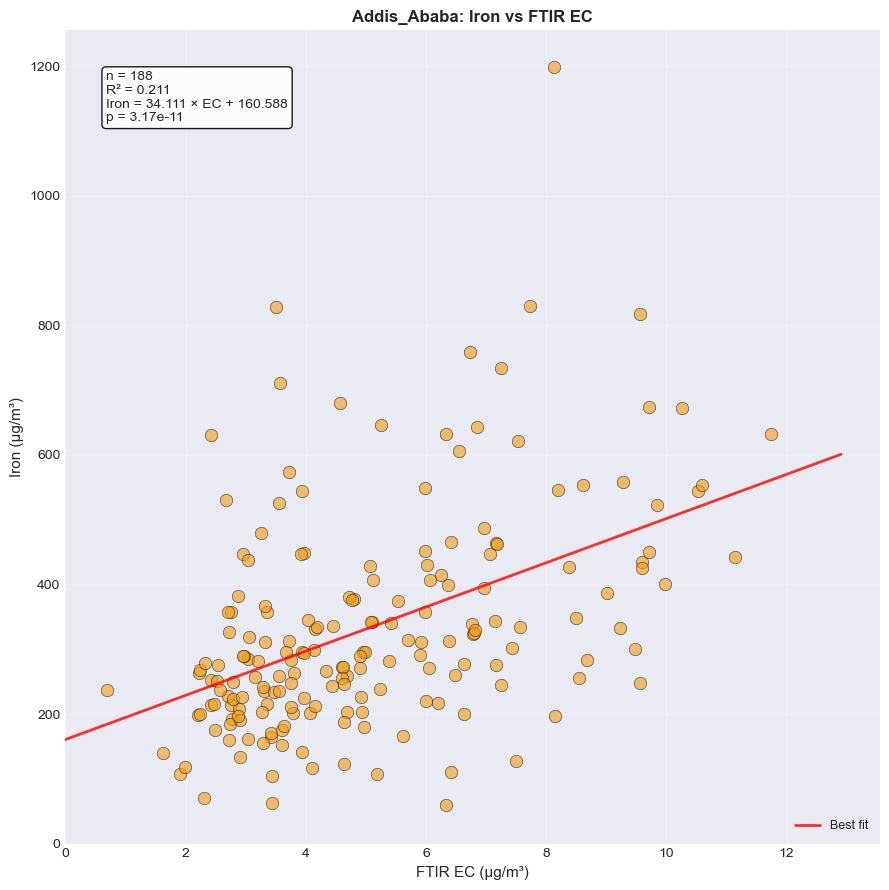

In [101]:
# Iron vs EC Scatter Plots with Regression

print("\n" + "="*60)
print("IRON vs FTIR EC CORRELATION ANALYSIS")
print("="*60)

iron_ec_correlations = {}

for site_name, analysis in iron_ec_analysis.items():
    config = SITES[site_name]
    df = analysis['data']
    
    fig, ax = plt.subplots(figsize=(9, 9))
    
    iron = df['iron'].values
    ec = df['ftir_ec'].values
    
    # Scatter plot
    ax.scatter(ec, iron, color=config['color'], alpha=0.6, s=80,
               edgecolors='black', linewidth=0.5)
    
    # Calculate regression
    valid_mask = (~np.isnan(iron)) & (~np.isnan(ec))
    iron_valid = iron[valid_mask]
    ec_valid = ec[valid_mask]
    
    if len(iron_valid) >= 3:
        slope, intercept, r_value, p_value, std_err = stats.linregress(ec_valid, iron_valid)
        r_squared = r_value ** 2
        
        # Plot regression line
        x_line = np.array([0, ec_valid.max() * 1.1])
        y_line = slope * x_line + intercept
        ax.plot(x_line, y_line, 'r-', linewidth=2, alpha=0.8, label='Best fit')
        
        # Stats text
        sign = '+' if intercept >= 0 else '-'
        eq = f"Iron = {slope:.3f} × EC {sign} {abs(intercept):.3f}"
        stats_text = f"n = {len(iron_valid)}\nR² = {r_squared:.3f}\n{eq}\np = {p_value:.2e}"
        ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
        
        iron_ec_correlations[site_name] = {
            'n': len(iron_valid),
            'r_squared': r_squared,
            'slope': slope,
            'intercept': intercept,
            'p_value': p_value
        }
        
        print(f"\n{site_name}:")
        print(f"  R² = {r_squared:.3f}")
        print(f"  Slope = {slope:.3f} (Iron per unit EC)")
        print(f"  p-value = {p_value:.2e}")
    
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)
    ax.set_xlabel('FTIR EC (µg/m³)', fontsize=11)
    ax.set_ylabel('Iron (µg/m³)', fontsize=11)
    ax.set_title(f'{site_name}: Iron vs FTIR EC', fontsize=12, fontweight='bold')
    ax.legend(loc='lower right', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()




DOES HIGH IRON/EC RATIO AFFECT AETHALOMETER-EC AGREEMENT?


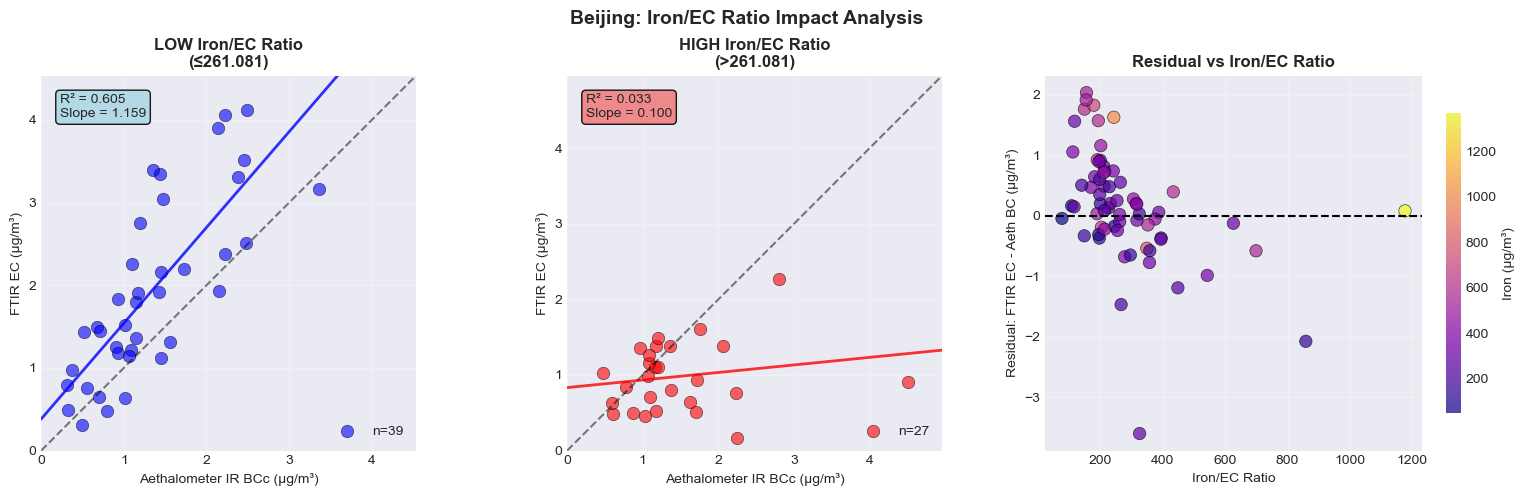


Beijing:
  Correlation (Iron/EC ratio vs EC-Aeth residual): r = -0.429, p = 0.000


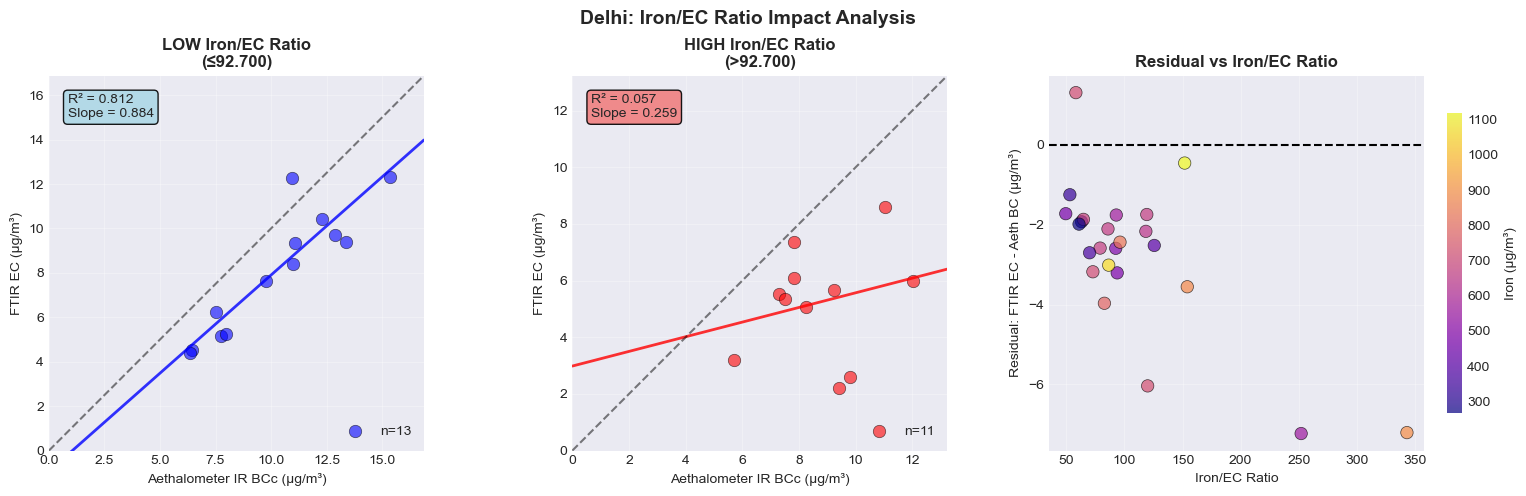


Delhi:
  Correlation (Iron/EC ratio vs EC-Aeth residual): r = -0.717, p = 0.000


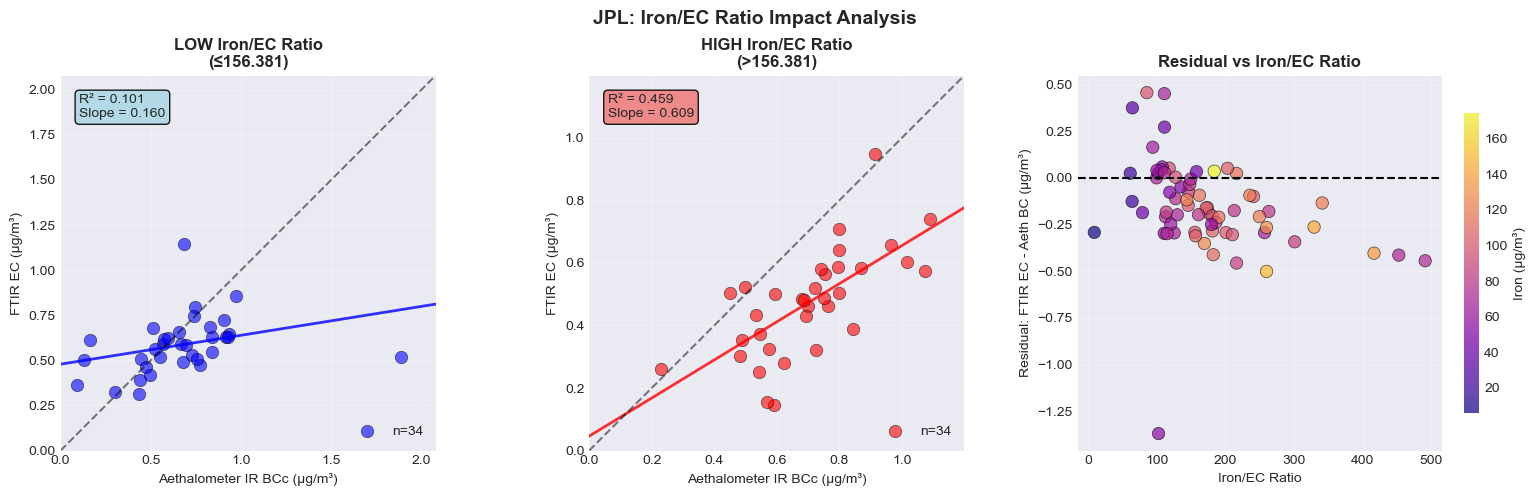


JPL:
  Correlation (Iron/EC ratio vs EC-Aeth residual): r = -0.349, p = 0.003


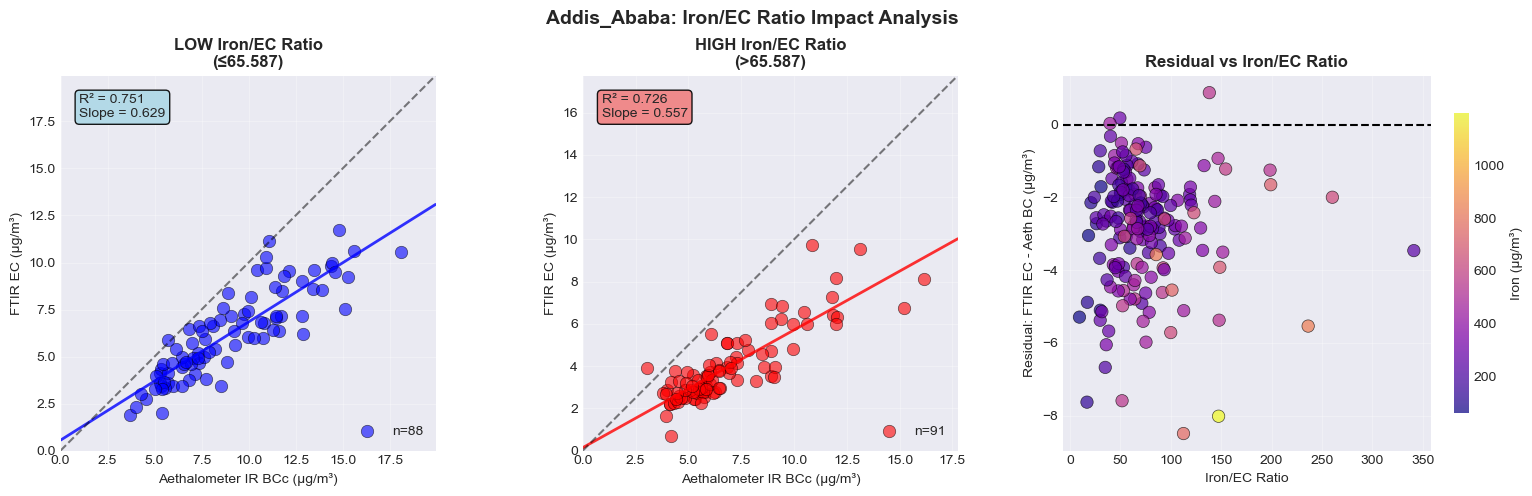


Addis_Ababa:
  Correlation (Iron/EC ratio vs EC-Aeth residual): r = -0.011, p = 0.882


In [102]:
# Iron/EC Ratio vs Other Variables
# Check if high Iron/EC ratio samples deviate from Aeth-EC regression

print("\n" + "="*60)
print("DOES HIGH IRON/EC RATIO AFFECT AETHALOMETER-EC AGREEMENT?")
print("="*60)

for site_name, analysis in iron_ec_analysis.items():
    config = SITES[site_name]
    df = analysis['data']
    
    # Need aeth BC data too
    if 'ir_bcc' not in df.columns:
        print(f"\n{site_name}: No aethalometer BC data")
        continue
    
    # Calculate ratio percentiles
    ratio_median = df['iron_ec_ratio'].median()
    
    # Split into high and low ratio groups
    high_ratio = df[df['iron_ec_ratio'] > ratio_median].copy()
    low_ratio = df[df['iron_ec_ratio'] <= ratio_median].copy()
    
    if len(high_ratio) < 3 or len(low_ratio) < 3:
        print(f"\n{site_name}: Insufficient data for split analysis")
        continue
    
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    # 1. Low Iron/EC ratio samples
    ax1 = axes[0]
    x_low = low_ratio['ir_bcc'].values
    y_low = low_ratio['ftir_ec'].values
    valid_low = (~np.isnan(x_low)) & (~np.isnan(y_low))
    
    ax1.scatter(x_low[valid_low], y_low[valid_low], color='blue', alpha=0.6, s=80,
               edgecolors='black', linewidth=0.5, label=f'n={valid_low.sum()}')
    
    if valid_low.sum() >= 3:
        slope, intercept, r_value, _, _ = stats.linregress(x_low[valid_low], y_low[valid_low])
        max_val = max(x_low[valid_low].max(), y_low[valid_low].max()) * 1.1
        x_line = np.array([0, max_val])
        ax1.plot(x_line, slope * x_line + intercept, 'b-', linewidth=2, alpha=0.8)
        ax1.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, linewidth=1.5)
        ax1.set_xlim(0, max_val)
        ax1.set_ylim(0, max_val)
        ax1.text(0.05, 0.95, f'R² = {r_value**2:.3f}\nSlope = {slope:.3f}', 
                transform=ax1.transAxes, fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.9))
    
    ax1.set_aspect('equal', adjustable='box')
    ax1.set_xlabel('Aethalometer IR BCc (µg/m³)')
    ax1.set_ylabel('FTIR EC (µg/m³)')
    ax1.set_title(f'LOW Iron/EC Ratio\n(≤{ratio_median:.3f})', fontweight='bold')
    ax1.legend(loc='lower right')
    ax1.grid(True, alpha=0.3)
    
    # 2. High Iron/EC ratio samples
    ax2 = axes[1]
    x_high = high_ratio['ir_bcc'].values
    y_high = high_ratio['ftir_ec'].values
    valid_high = (~np.isnan(x_high)) & (~np.isnan(y_high))
    
    ax2.scatter(x_high[valid_high], y_high[valid_high], color='red', alpha=0.6, s=80,
               edgecolors='black', linewidth=0.5, label=f'n={valid_high.sum()}')
    
    if valid_high.sum() >= 3:
        slope, intercept, r_value, _, _ = stats.linregress(x_high[valid_high], y_high[valid_high])
        max_val = max(x_high[valid_high].max(), y_high[valid_high].max()) * 1.1
        x_line = np.array([0, max_val])
        ax2.plot(x_line, slope * x_line + intercept, 'r-', linewidth=2, alpha=0.8)
        ax2.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, linewidth=1.5)
        ax2.set_xlim(0, max_val)
        ax2.set_ylim(0, max_val)
        ax2.text(0.05, 0.95, f'R² = {r_value**2:.3f}\nSlope = {slope:.3f}', 
                transform=ax2.transAxes, fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.9))
    
    ax2.set_aspect('equal', adjustable='box')
    ax2.set_xlabel('Aethalometer IR BCc (µg/m³)')
    ax2.set_ylabel('FTIR EC (µg/m³)')
    ax2.set_title(f'HIGH Iron/EC Ratio\n(>{ratio_median:.3f})', fontweight='bold')
    ax2.legend(loc='lower right')
    ax2.grid(True, alpha=0.3)
    
    # 3. Iron/EC ratio vs Aeth-EC residual
    ax3 = axes[2]
    
    # Calculate residual from 1:1 line - include 'iron' column for colorbar
    all_valid = df[['ir_bcc', 'ftir_ec', 'iron_ec_ratio', 'iron']].dropna()
    residual = all_valid['ftir_ec'] - all_valid['ir_bcc']  # EC - Aeth

    ax3.scatter(all_valid['iron_ec_ratio'], residual, c=all_valid['iron'], 
               cmap='plasma', alpha=0.7, s=80, edgecolors='black', linewidth=0.5)
    ax3.axhline(y=0, color='black', linestyle='--', linewidth=1.5)
    
    # Add colorbar
    cbar = plt.colorbar(ax3.collections[0], ax=ax3, shrink=0.8)
    cbar.set_label('Iron (µg/m³)', fontsize=10)
    
    ax3.set_xlabel('Iron/EC Ratio')
    ax3.set_ylabel('Residual: FTIR EC - Aeth BC (µg/m³)')
    ax3.set_title('Residual vs Iron/EC Ratio', fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    plt.suptitle(f'{site_name}: Iron/EC Ratio Impact Analysis', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Calculate correlation between Iron/EC ratio and residual
    corr, p_val = stats.pearsonr(all_valid['iron_ec_ratio'], residual)
    print(f"\n{site_name}:")
    print(f"  Correlation (Iron/EC ratio vs EC-Aeth residual): r = {corr:.3f}, p = {p_val:.3f}")

## 6b. Iron vs HIPS Fabs Cross-Plots

Compare Iron concentrations with HIPS Fabs measurements for each site.

In [ ]:
# Iron vs HIPS Fabs Cross-Plots for each site

print("="*60)
print("IRON vs HIPS Fabs CROSS-PLOTS")
print("="*60)

iron_hips_stats = {}

for site_name, matched_df in all_params_data.items():
    config = SITES[site_name]
    
    # Check if iron and hips_fabs data exist
    if 'iron' not in matched_df.columns or 'hips_fabs' not in matched_df.columns:
        print(f"\n{site_name}: Missing iron or HIPS Fabs columns")
        continue
    
    # Apply exclusion flags
    df_flagged = apply_exclusion_flags(matched_df.copy(), site_name)
    
    # Filter to points with both iron and hips_fabs
    valid_mask = (df_flagged['iron'].notna()) & (df_flagged['hips_fabs'].notna())
    
    # Exclude flagged outliers
    if 'is_excluded' in df_flagged.columns:
        clean_mask = valid_mask & ~df_flagged['is_excluded']
    else:
        clean_mask = valid_mask
    
    df_clean = df_flagged[clean_mask].copy()
    
    if len(df_clean) < 3:
        print(f"\n{site_name}: Insufficient data (n={len(df_clean)})")
        continue
    
    iron = df_clean['iron'].values
    hips = df_clean['hips_fabs'].values
    
    # Create figure
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Scatter plot
    ax.scatter(iron, hips, color=config['color'], alpha=0.6, s=80,
               edgecolors='black', linewidth=0.5)
    
    # Calculate regression
    valid_idx = (~np.isnan(iron)) & (~np.isnan(hips))
    iron_valid = iron[valid_idx]
    hips_valid = hips[valid_idx]
    
    if len(iron_valid) >= 3:
        slope, intercept, r_value, p_value, std_err = stats.linregress(iron_valid, hips_valid)
        r_squared = r_value ** 2
        
        # Determine axis max
        max_val = max(iron_valid.max(), hips_valid.max()) * 1.15
        
        # Plot regression line
        x_line = np.array([0, max_val])
        y_line = slope * x_line + intercept
        ax.plot(x_line, y_line, 'r-', linewidth=2, alpha=0.8, label='Best fit')
        
        # 1:1 line
        ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, linewidth=1.5, label='1:1 line')
        
        # Set axis limits
        ax.set_xlim(0, max_val)
        ax.set_ylim(0, max_val)
        ax.set_aspect('equal', adjustable='box')
        
        # Stats text
        sign = '+' if intercept >= 0 else '-'
        eq = f"y = {slope:.3f}x {sign} {abs(intercept):.3f}"
        stats_text = f"n = {len(iron_valid)}\nR² = {r_squared:.3f}\n{eq}"
        ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
        
        iron_hips_stats[site_name] = {
            'n': len(iron_valid),
            'r_squared': r_squared,
            'slope': slope,
            'intercept': intercept,
            'p_value': p_value
        }
        
        print(f"\n{site_name}:")
        print(f"  n = {len(iron_valid)}")
        print(f"  R² = {r_squared:.3f}")
        print(f"  Slope = {slope:.3f}")
    
    ax.set_xlabel('Iron (µg/m³)', fontsize=11)
    ax.set_ylabel('HIPS Fabs / MAC (µg/m³)', fontsize=11)
    ax.set_title(f'{site_name}: Iron vs HIPS Fabs', fontsize=12, fontweight='bold')
    ax.legend(loc='lower right', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 6c. Iron vs Aethalometer BCc Cross-Plots

Compare Iron concentrations with Aethalometer IR BCc measurements for each site.

In [ ]:
# Iron vs Aethalometer IR BCc Cross-Plots for each site

print("="*60)
print("IRON vs AETHALOMETER IR BCc CROSS-PLOTS")
print("="*60)

iron_bcc_stats = {}

for site_name, matched_df in all_params_data.items():
    config = SITES[site_name]
    
    # Check if iron and ir_bcc data exist
    if 'iron' not in matched_df.columns or 'ir_bcc' not in matched_df.columns:
        print(f"\n{site_name}: Missing iron or IR BCc columns")
        continue
    
    # Apply exclusion flags
    df_flagged = apply_exclusion_flags(matched_df.copy(), site_name)
    
    # Filter to points with both iron and ir_bcc
    valid_mask = (df_flagged['iron'].notna()) & (df_flagged['ir_bcc'].notna())
    
    # Exclude flagged outliers
    if 'is_excluded' in df_flagged.columns:
        clean_mask = valid_mask & ~df_flagged['is_excluded']
    else:
        clean_mask = valid_mask
    
    df_clean = df_flagged[clean_mask].copy()
    
    if len(df_clean) < 3:
        print(f"\n{site_name}: Insufficient data (n={len(df_clean)})")
        continue
    
    iron = df_clean['iron'].values
    bcc = df_clean['ir_bcc'].values
    
    # Create figure
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Scatter plot
    ax.scatter(iron, bcc, color=config['color'], alpha=0.6, s=80,
               edgecolors='black', linewidth=0.5)
    
    # Calculate regression
    valid_idx = (~np.isnan(iron)) & (~np.isnan(bcc))
    iron_valid = iron[valid_idx]
    bcc_valid = bcc[valid_idx]
    
    if len(iron_valid) >= 3:
        slope, intercept, r_value, p_value, std_err = stats.linregress(iron_valid, bcc_valid)
        r_squared = r_value ** 2
        
        # Determine axis max
        max_val = max(iron_valid.max(), bcc_valid.max()) * 1.15
        
        # Plot regression line
        x_line = np.array([0, max_val])
        y_line = slope * x_line + intercept
        ax.plot(x_line, y_line, 'r-', linewidth=2, alpha=0.8, label='Best fit')
        
        # 1:1 line
        ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, linewidth=1.5, label='1:1 line')
        
        # Set axis limits
        ax.set_xlim(0, max_val)
        ax.set_ylim(0, max_val)
        ax.set_aspect('equal', adjustable='box')
        
        # Stats text
        sign = '+' if intercept >= 0 else '-'
        eq = f"y = {slope:.3f}x {sign} {abs(intercept):.3f}"
        stats_text = f"n = {len(iron_valid)}\nR² = {r_squared:.3f}\n{eq}"
        ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
        
        iron_bcc_stats[site_name] = {
            'n': len(iron_valid),
            'r_squared': r_squared,
            'slope': slope,
            'intercept': intercept,
            'p_value': p_value
        }
        
        print(f"\n{site_name}:")
        print(f"  n = {len(iron_valid)}")
        print(f"  R² = {r_squared:.3f}")
        print(f"  Slope = {slope:.3f}")
    
    ax.set_xlabel('Iron (µg/m³)', fontsize=11)
    ax.set_ylabel('Aethalometer IR BCc (µg/m³)', fontsize=11)
    ax.set_title(f'{site_name}: Iron vs Aethalometer BCc', fontsize=12, fontweight='bold')
    ax.legend(loc='lower right', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [ ]:
# Summary table for Iron cross-comparisons

print("\n" + "="*100)
print("SUMMARY: IRON CROSS-COMPARISON STATISTICS")
print("="*100)

print("\n--- Iron vs HIPS Fabs ---")
print(f"{'Site':<25s} {'n':>6s} {'R²':>8s} {'Slope':>8s} {'Intercept':>10s}")
print("-"*60)
for site_name in SITES:
    if site_name in iron_hips_stats:
        s = iron_hips_stats[site_name]
        print(f"{site_name:<25s} {s['n']:>6d} {s['r_squared']:>8.3f} {s['slope']:>8.3f} {s['intercept']:>10.3f}")
    else:
        print(f"{site_name:<25s} {'--':>6s} {'--':>8s} {'--':>8s} {'--':>10s}")

print("\n--- Iron vs Aethalometer IR BCc ---")
print(f"{'Site':<25s} {'n':>6s} {'R²':>8s} {'Slope':>8s} {'Intercept':>10s}")
print("-"*60)
for site_name in SITES:
    if site_name in iron_bcc_stats:
        s = iron_bcc_stats[site_name]
        print(f"{site_name:<25s} {s['n']:>6d} {s['r_squared']:>8.3f} {s['slope']:>8.3f} {s['intercept']:>10.3f}")
    else:
        print(f"{site_name:<25s} {'--':>6s} {'--':>8s} {'--':>8s} {'--':>10s}")

---
# TASK 4: Summary Tables

Create comprehensive summary tables with slopes and R² values for all cross-plots.



## 7. Comprehensive Summary Tables



In [103]:
# Generate comprehensive summary statistics for all sites and comparisons

print("="*80)
print("COMPREHENSIVE SUMMARY TABLES")
print("="*80)

# Collect all cross-comparison results
summary_results = {}

cross_comparisons_full = [
    ('ir_bcc', 'ftir_ec', 'Aeth IR BCc vs FTIR EC'),
    ('ir_bcc', 'hips_fabs', 'Aeth IR BCc vs HIPS Fabs'),
    ('ftir_ec', 'hips_fabs', 'FTIR EC vs HIPS Fabs'),
    ('iron', 'ftir_ec', 'Iron vs FTIR EC'),
]

for site_name, matched_df in all_params_data.items():
    config = SITES[site_name]
    site_results = {}
    
    # Apply exclusion flags
    df_flagged = apply_exclusion_flags(matched_df.copy(), site_name)
    
    for x_col, y_col, comp_name in cross_comparisons_full:
        if x_col not in df_flagged.columns or y_col not in df_flagged.columns:
            continue
        
        # Get valid data
        valid_mask = (~np.isnan(df_flagged[x_col].values)) & (~np.isnan(df_flagged[y_col].values))
        
        if 'is_excluded' in df_flagged.columns:
            clean_mask = valid_mask & ~df_flagged['is_excluded'].values
        else:
            clean_mask = valid_mask
        
        x_clean = df_flagged.loc[clean_mask, x_col].values
        y_clean = df_flagged.loc[clean_mask, y_col].values
        
        if len(x_clean) >= 3:
            slope, intercept, r_value, p_value, std_err = stats.linregress(x_clean, y_clean)
            
            site_results[comp_name] = {
                'n': len(x_clean),
                'r_squared': r_value ** 2,
                'slope': slope,
                'intercept': intercept,
                'p_value': p_value,
                'std_err': std_err
            }
    
    summary_results[site_name] = site_results



COMPREHENSIVE SUMMARY TABLES


In [104]:
# Print formatted summary tables

print("\n" + "="*100)
print("TABLE 1: AETHALOMETER IR BCc vs FTIR EC")
print("="*100)
comp = 'Aeth IR BCc vs FTIR EC'
print(f"\n{'Site':<25s} {'n':>6s} {'R²':>8s} {'Slope':>8s} {'Intercept':>10s} {'p-value':>12s}")
print("-"*75)
for site_name in SITES:
    if site_name in summary_results and comp in summary_results[site_name]:
        s = summary_results[site_name][comp]
        print(f"{site_name:<25s} {s['n']:>6d} {s['r_squared']:>8.3f} {s['slope']:>8.3f} "
              f"{s['intercept']:>10.3f} {s['p_value']:>12.2e}")
    else:
        print(f"{site_name:<25s} {'--':>6s} {'--':>8s} {'--':>8s} {'--':>10s} {'--':>12s}")

print("\n" + "="*100)
print("TABLE 2: AETHALOMETER IR BCc vs HIPS Fabs")
print("="*100)
comp = 'Aeth IR BCc vs HIPS Fabs'
print(f"\n{'Site':<25s} {'n':>6s} {'R²':>8s} {'Slope':>8s} {'Intercept':>10s} {'p-value':>12s}")
print("-"*75)
for site_name in SITES:
    if site_name in summary_results and comp in summary_results[site_name]:
        s = summary_results[site_name][comp]
        print(f"{site_name:<25s} {s['n']:>6d} {s['r_squared']:>8.3f} {s['slope']:>8.3f} "
              f"{s['intercept']:>10.3f} {s['p_value']:>12.2e}")
    else:
        print(f"{site_name:<25s} {'--':>6s} {'--':>8s} {'--':>8s} {'--':>10s} {'--':>12s}")

print("\n" + "="*100)
print("TABLE 3: FTIR EC vs HIPS Fabs")
print("="*100)
comp = 'FTIR EC vs HIPS Fabs'
print(f"\n{'Site':<25s} {'n':>6s} {'R²':>8s} {'Slope':>8s} {'Intercept':>10s} {'p-value':>12s}")
print("-"*75)
for site_name in SITES:
    if site_name in summary_results and comp in summary_results[site_name]:
        s = summary_results[site_name][comp]
        print(f"{site_name:<25s} {s['n']:>6d} {s['r_squared']:>8.3f} {s['slope']:>8.3f} "
              f"{s['intercept']:>10.3f} {s['p_value']:>12.2e}")
    else:
        print(f"{site_name:<25s} {'--':>6s} {'--':>8s} {'--':>8s} {'--':>10s} {'--':>12s}")

print("\n" + "="*100)
print("TABLE 4: IRON vs FTIR EC")
print("="*100)
comp = 'Iron vs FTIR EC'
print(f"\n{'Site':<25s} {'n':>6s} {'R²':>8s} {'Slope':>8s} {'Intercept':>10s} {'p-value':>12s}")
print("-"*75)
for site_name in SITES:
    if site_name in summary_results and comp in summary_results[site_name]:
        s = summary_results[site_name][comp]
        print(f"{site_name:<25s} {s['n']:>6d} {s['r_squared']:>8.3f} {s['slope']:>8.3f} "
              f"{s['intercept']:>10.3f} {s['p_value']:>12.2e}")
    else:
        print(f"{site_name:<25s} {'--':>6s} {'--':>8s} {'--':>8s} {'--':>10s} {'--':>12s}")




TABLE 1: AETHALOMETER IR BCc vs FTIR EC

Site                           n       R²    Slope  Intercept      p-value
---------------------------------------------------------------------------
Beijing                       72    0.227    0.606      0.643     2.35e-05
Delhi                         25    0.608    0.942     -2.336     4.35e-06
JPL                           68    0.151    0.258      0.353     1.07e-03
Addis_Ababa                  180    0.734    0.646     -0.011     4.25e-53

TABLE 2: AETHALOMETER IR BCc vs HIPS Fabs

Site                           n       R²    Slope  Intercept      p-value
---------------------------------------------------------------------------
Beijing                       72    0.404    0.587      0.628     1.96e-09
Delhi                         25    0.609    0.519      1.369     4.18e-06
JPL                           68    0.326    0.376      0.278     3.67e-07
Addis_Ababa                  180    0.623    0.265      2.788     1.57e-39

TABLE 3: FT

In [105]:
# Iron/EC Ratio Summary Table

print("\n" + "="*100)
print("TABLE 5: IRON/EC RATIO STATISTICS BY SITE")
print("="*100)
print(f"\n{'Site':<25s} {'n':>6s} {'Mean':>8s} {'Median':>8s} {'Std':>8s} {'Min':>8s} {'Max':>8s}")
print("-"*80)

for site_name, analysis in iron_ec_analysis.items():
    print(f"{site_name:<25s} {analysis['n']:>6d} {analysis['ratio_mean']:>8.3f} "
          f"{analysis['ratio_median']:>8.3f} {analysis['ratio_std']:>8.3f} "
          f"{analysis['ratio_min']:>8.3f} {analysis['ratio_max']:>8.3f}")




TABLE 5: IRON/EC RATIO STATISTICS BY SITE

Site                           n     Mean   Median      Std      Min      Max
--------------------------------------------------------------------------------
Beijing                      168  604.423  261.081 3097.929   76.536 40175.061
Delhi                         26  131.297   92.700  104.930   49.441  416.592
JPL                          155  174.165  156.381   98.478    4.262  659.398
Addis_Ababa                  188   73.562   65.587   42.262    9.430  341.213


In [106]:
# Create exportable DataFrame summary

summary_df_rows = []

for site_name in SITES:
    if site_name not in summary_results:
        continue
    
    for comp_name, stats in summary_results[site_name].items():
        summary_df_rows.append({
            'Site': site_name,
            'Comparison': comp_name,
            'n': stats['n'],
            'R²': stats['r_squared'],
            'Slope': stats['slope'],
            'Intercept': stats['intercept'],
            'p-value': stats['p_value'],
            'Std Error': stats['std_err']
        })

summary_df = pd.DataFrame(summary_df_rows)

print("\n" + "="*100)
print("EXPORTABLE SUMMARY (DataFrame format)")
print("="*100)
print(summary_df.to_string(index=False))

# Save to CSV (optional)
# summary_df.to_csv('cross_comparison_summary.csv', index=False)




EXPORTABLE SUMMARY (DataFrame format)
       Site               Comparison   n       R²    Slope  Intercept      p-value  Std Error
    Beijing   Aeth IR BCc vs FTIR EC  72 0.226811 0.606412   0.643156 2.351793e-05   0.133823
    Beijing Aeth IR BCc vs HIPS Fabs  72 0.404249 0.586869   0.628218 1.964720e-09   0.085153
    Beijing     FTIR EC vs HIPS Fabs 161 0.541069 0.557091   0.622968 1.097922e-28   0.040689
    Beijing          Iron vs FTIR EC 171 0.137072 0.001027   1.006608 6.222488e-07   0.000198
      Delhi   Aeth IR BCc vs FTIR EC  25 0.607861 0.942179  -2.335963 4.349191e-06   0.157793
      Delhi Aeth IR BCc vs HIPS Fabs  25 0.609168 0.518824   1.369458 4.181369e-06   0.086653
      Delhi     FTIR EC vs HIPS Fabs  63 0.763893 0.382289   2.331619 8.784568e-21   0.027212
      Delhi          Iron vs FTIR EC  27 0.051560 0.002996   4.210656 2.547022e-01   0.002570
        JPL   Aeth IR BCc vs FTIR EC  68 0.150672 0.258422   0.353389 1.072374e-03   0.075523
        JPL Aeth IR B

## 8. Exclusion Registry Summary



In [107]:
# Print comprehensive exclusion summary

print("\n" + "="*100)
print("EXCLUSION REGISTRY SUMMARY")
print("="*100)

print("\n--- MANUAL OUTLIERS (from EXCLUDED_SAMPLES) ---")
for site, exclusions in EXCLUSION_REGISTRY['manual_outliers'].items():
    if exclusions:
        print(f"\n{site}: {len(exclusions)} exclusion(s)")
        for excl in exclusions:
            print(f"  - {excl['date']}: {excl['reason'][:60]}...")

print("\n--- DELHI GREEN WAVELENGTH OUTLIERS ---")
if EXCLUSION_REGISTRY['delhi_green_outliers']:
    print(f"\nDelhi: {len(EXCLUSION_REGISTRY['delhi_green_outliers'])} green wavelength outlier(s)")
    for outlier in EXCLUSION_REGISTRY['delhi_green_outliers']:
        print(f"  - {outlier['date']}: {outlier['value']:.1f} ng/m³")
else:
    print("  No Delhi green wavelength outliers identified")

# Count total exclusions per site
print("\n--- TOTAL EXCLUSIONS BY SITE ---")
total_exclusions = {}
for site in SITES:
    count = len(EXCLUSION_REGISTRY['manual_outliers'].get(site, []))
    if site == 'Delhi, India (INDH)':
        count += len(EXCLUSION_REGISTRY['delhi_green_outliers'])
    total_exclusions[site] = count

for site, count in total_exclusions.items():
    print(f"  {site}: {count} total exclusion(s)")




EXCLUSION REGISTRY SUMMARY

--- MANUAL OUTLIERS (from EXCLUDED_SAMPLES) ---

Beijing: 1 exclusion(s)
  - 2022-05-15: Extreme aethalometer BC outlier - affects slope significantl...

Delhi: 2 exclusion(s)
  - 2023-01-10: High aethalometer (~10000) with low FTIR EC (~2000) - measur...
  - 2023-01-15: High aethalometer (~9500) with low FTIR EC (~2500) - measure...

JPL: 2 exclusion(s)
  - 2022-06-20: Pre-flow-fix period - aethalometer BC > 1700 threshold...
  - 2022-07-05: FTIR EC > 1000 threshold - likely contamination...

--- DELHI GREEN WAVELENGTH OUTLIERS ---
  No Delhi green wavelength outliers identified

--- TOTAL EXCLUSIONS BY SITE ---
  Beijing: 1 total exclusion(s)
  Delhi: 2 total exclusion(s)
  JPL: 2 total exclusion(s)
  Addis_Ababa: 0 total exclusion(s)


## 9. Final Multi-Panel Summary Plot



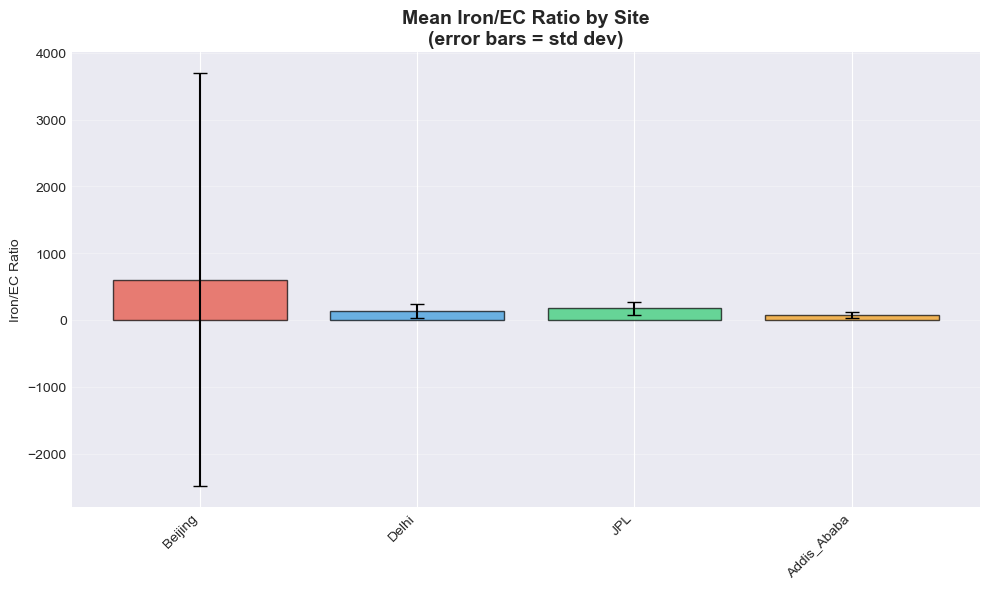

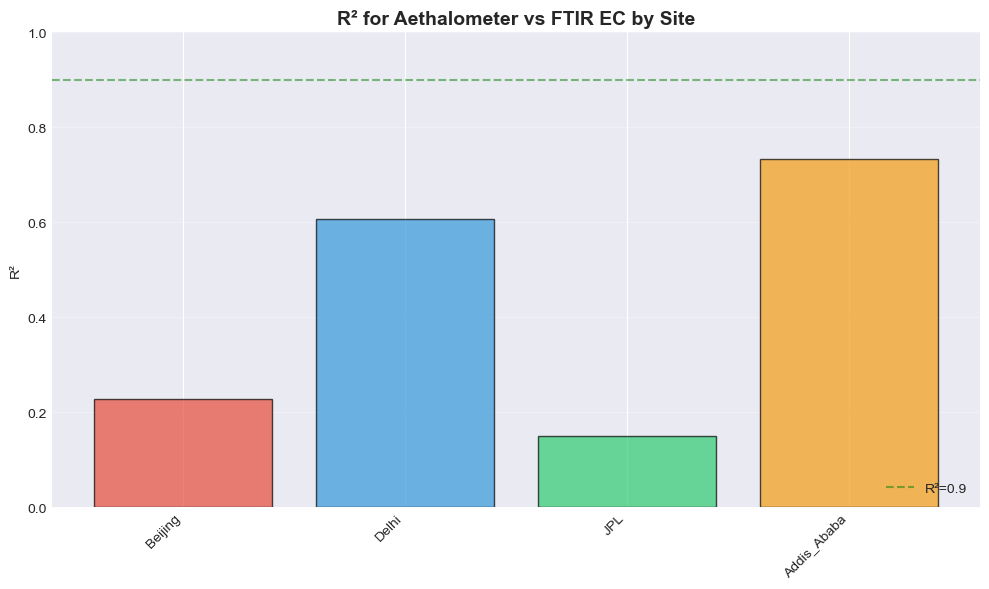

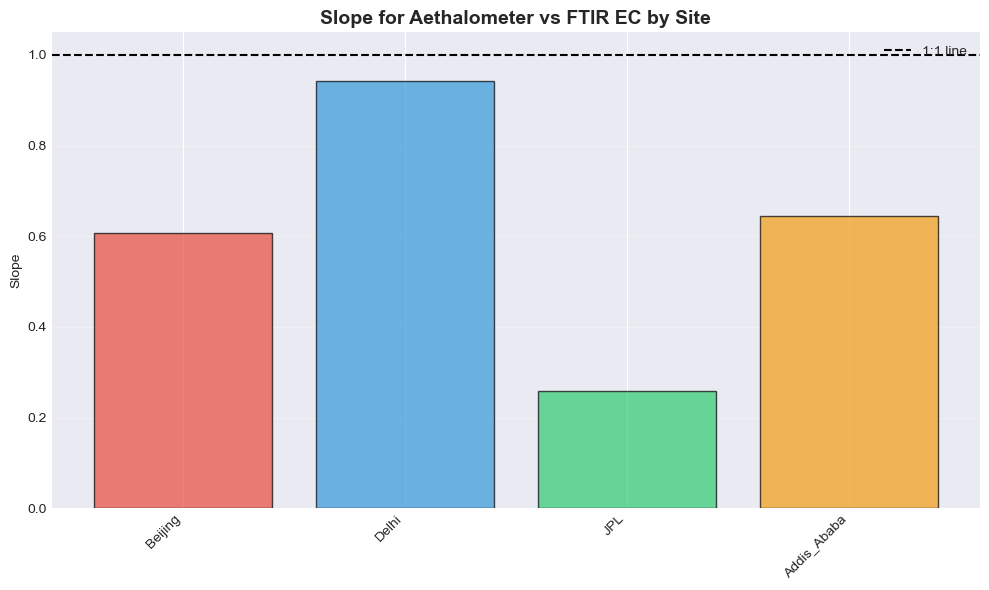

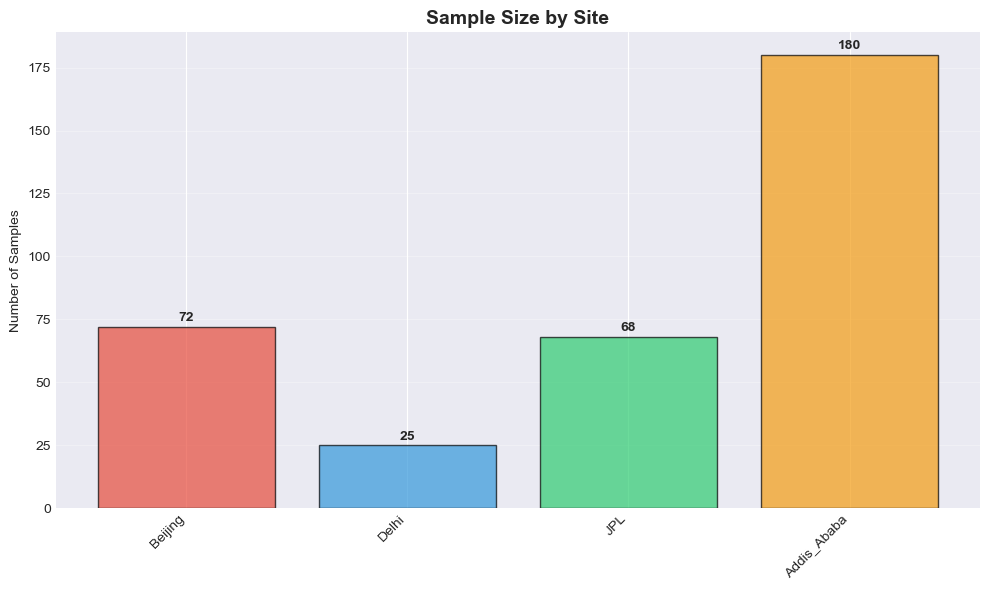

Generated 4 separate summary figures.


In [108]:
# Create separate individual summary figures

# Figure 1: Iron/EC ratio comparison across sites
fig1, ax1 = plt.subplots(figsize=(10, 6))
sites_with_ratio = list(iron_ec_analysis.keys())
ratio_means = [iron_ec_analysis[s]['ratio_mean'] for s in sites_with_ratio]
ratio_stds = [iron_ec_analysis[s]['ratio_std'] for s in sites_with_ratio]
colors = [SITES[s]['color'] for s in sites_with_ratio]

bars = ax1.bar(range(len(sites_with_ratio)), ratio_means, yerr=ratio_stds,
               color=colors, alpha=0.7, edgecolor='black', linewidth=1, capsize=5)
ax1.set_xticks(range(len(sites_with_ratio)))
ax1.set_xticklabels([s.split(',')[0] for s in sites_with_ratio], rotation=45, ha='right')
ax1.set_ylabel('Iron/EC Ratio')
ax1.set_title('Mean Iron/EC Ratio by Site\n(error bars = std dev)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Figure 2: R² comparison for Aeth vs FTIR EC
fig2, ax2 = plt.subplots(figsize=(10, 6))
comp = 'Aeth IR BCc vs FTIR EC'
sites_with_data = [s for s in SITES if s in summary_results and comp in summary_results[s]]
r2_values = [summary_results[s][comp]['r_squared'] for s in sites_with_data]
colors = [SITES[s]['color'] for s in sites_with_data]

bars = ax2.bar(range(len(sites_with_data)), r2_values, color=colors, 
               alpha=0.7, edgecolor='black', linewidth=1)
ax2.set_xticks(range(len(sites_with_data)))
ax2.set_xticklabels([s.split(',')[0] for s in sites_with_data], rotation=45, ha='right')
ax2.set_ylabel('R²')
ax2.set_ylim(0, 1)
ax2.set_title('R² for Aethalometer vs FTIR EC by Site', fontsize=14, fontweight='bold')
ax2.axhline(y=0.9, color='green', linestyle='--', alpha=0.5, label='R²=0.9')
ax2.grid(True, alpha=0.3, axis='y')
ax2.legend(loc='lower right')
plt.tight_layout()
plt.show()

# Figure 3: Slope comparison for Aeth vs FTIR EC
fig3, ax3 = plt.subplots(figsize=(10, 6))
slope_values = [summary_results[s][comp]['slope'] for s in sites_with_data]

bars = ax3.bar(range(len(sites_with_data)), slope_values, color=colors,
               alpha=0.7, edgecolor='black', linewidth=1)
ax3.set_xticks(range(len(sites_with_data)))
ax3.set_xticklabels([s.split(',')[0] for s in sites_with_data], rotation=45, ha='right')
ax3.set_ylabel('Slope')
ax3.axhline(y=1.0, color='black', linestyle='--', linewidth=1.5, label='1:1 line')
ax3.set_title('Slope for Aethalometer vs FTIR EC by Site', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')
ax3.legend(loc='best')
plt.tight_layout()
plt.show()

# Figure 4: Sample sizes
fig4, ax4 = plt.subplots(figsize=(10, 6))
n_values = [summary_results[s][comp]['n'] for s in sites_with_data]

bars = ax4.bar(range(len(sites_with_data)), n_values, color=colors,
               alpha=0.7, edgecolor='black', linewidth=1)
ax4.set_xticks(range(len(sites_with_data)))
ax4.set_xticklabels([s.split(',')[0] for s in sites_with_data], rotation=45, ha='right')
ax4.set_ylabel('Number of Samples')
ax4.set_title('Sample Size by Site', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

# Add sample count labels on bars
for i, (bar, n) in enumerate(zip(bars, n_values)):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             str(n), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("Generated 4 separate summary figures.")

---

## Summary of Completed Tasks

### Task 1: Delhi Green Wavelength Outliers ✅
- Identified outliers using IQR method
- Created before/after comparison plots
- Added outliers to EXCLUSION_REGISTRY

### Task 2: Delhi Axis Scaling Fix ✅
- Created comparison showing incorrect (60) vs correct (auto-scaled) axes
- Implemented `create_scaled_crossplot()` function with proper scaling

### Task 3: Iron/EC Ratio Analysis ✅
- Calculated Iron/EC ratio for all sites
- Distribution plots by site
- Iron vs EC scatter plots with regression
- Analysis of whether high Iron/EC ratio affects Aeth-EC agreement

### Task 4: Summary Tables ✅
- TABLE 1: Aeth IR BCc vs FTIR EC
- TABLE 2: Aeth IR BCc vs HIPS Fabs  
- TABLE 3: FTIR EC vs HIPS Fabs
- TABLE 4: Iron vs FTIR EC
- TABLE 5: Iron/EC Ratio Statistics
- Exportable DataFrame format

### Exclusion Registry ✅
- Maintains all manual outliers
- Tracks Delhi green wavelength outliers
- Summary counts per site

---

## Next Steps (Remaining Tasks)

1. **Cross-plot collage PowerPoint** - Create presentation with all plots
2. **Raw attenuation correlation matrix** - Requires raw ATN data
3. **Hourly-binned wavelength ratio** - For Ångström exponent analysis
4. **Matched-sample plots** - Strict three-way matching